In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2 

In [2]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(["science", "no-latex", "grid"])

In [28]:
df = pl.read_parquet("../result.parquet")

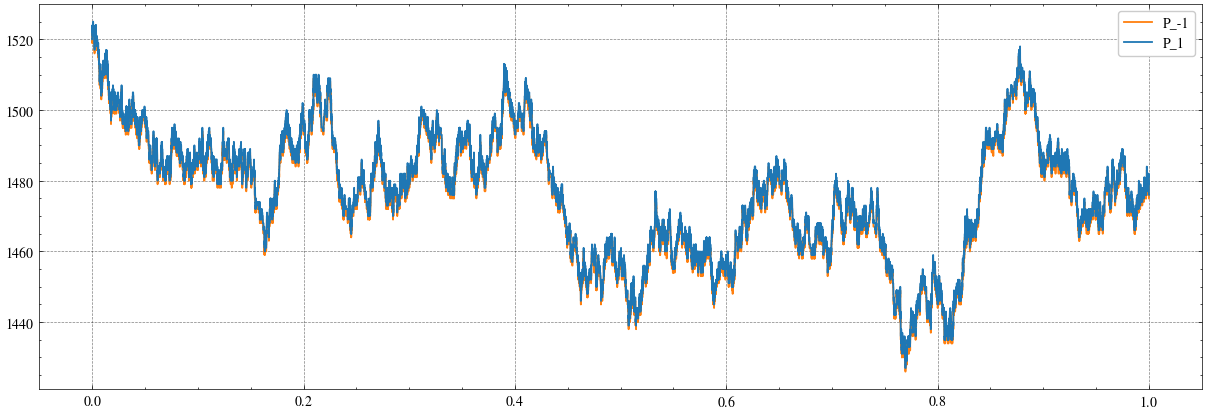

In [29]:
plt.figure(figsize=(15, 5))

df_ = df[::100]
plt.plot(
    df_["timestamp"] / df_["timestamp"].max(),
    df_["best_bid_price"],
    label="P_-1",
    lw=1.3,
    color="tab:orange",
)
plt.plot(
    df_["timestamp"] / df_["timestamp"].max(),
    df_["best_ask_price"],
    label="P_1",
    lw=1.3,
    color="tab:blue",
)

plt.legend()
plt.show()

In [40]:
v = (
    df.filter(pl.col("type").eq("Trade"))
    .with_columns((pl.col("timestamp") // (3600 * 1_000_000_000)).alias("hour"))
    .group_by("hour")
    .agg(pl.col("volume").sum().alias("size"))
    .sort("hour")
)

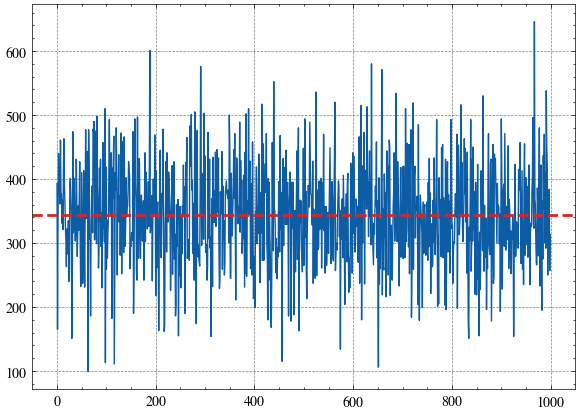

In [41]:
plt.figure(figsize=(7, 5))
plt.plot(v["size"])
plt.axhline(v["size"].mean(), linestyle="--", lw=2, color="tab:red")
plt.show()

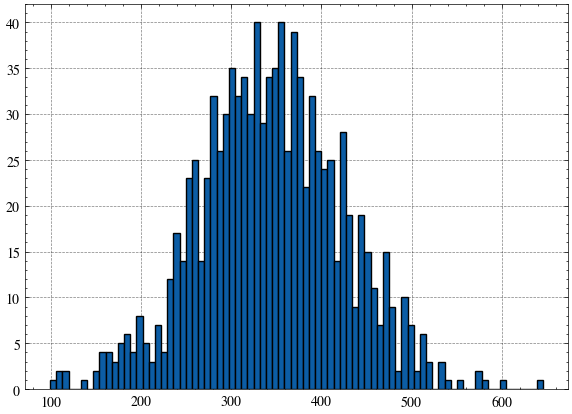

In [42]:
plt.figure(figsize=(7, 5))
plt.hist(v["size"], bins=80, edgecolor="k");

In [43]:
def plot_impact(df, include_trade_probs=False, warmup_ns=int(1e9) * 60 * 5):
    if include_trade_probs:
        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 2)
        ax1 = fig.add_subplot(gs[0, :])
        ax2 = fig.add_subplot(gs[1, :])
        ax3 = fig.add_subplot(gs[2, 0])
        ax4 = fig.add_subplot(gs[2, 1], sharey=ax3)
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    max_ts = df["timestamp"].max()
    warmup_x = warmup_ns / max_ts
    x = df["timestamp"] / max_ts

    # Row 1: avg_mid_price_change
    ax1.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
    ax1.plot(x, df["avg_mid_price_change"], linewidth=2)
    ax1.set_xlabel("time")
    ax1.set_ylabel(r"$E[P_t - P_0]$")

    # Row 2: avg_bias
    ax2.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
    ax2.plot(x, df["avg_bias"], linewidth=2)
    ax2.set_xlabel("time")
    ax2.set_ylabel(r"$\phi(t)$")

    if include_trade_probs:
        # Row 3 left: Bid trade probabilities
        ax3.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
        for i in range(10):
            ax3.plot(x, df[f"bin_{i}_bid_trade_prob"], linewidth=2, label=f"bin {i}")
        ax3.set_xlabel("time")
        ax3.set_ylabel("bid trade probability")
        ax3.legend()
        ax3.set_title("Bid Trade Probabilities")

        # Row 3 right: Ask trade probabilities
        ax4.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
        for i in range(10):
            ax4.plot(x, df[f"bin_{i}_ask_trade_prob"], linewidth=2, label=f"bin {i}")
        ax4.set_xlabel("time")
        ax4.set_ylabel("ask trade probability")
        ax4.legend()
        ax4.set_title("Ask Trade Probabilities")

    plt.tight_layout()
    plt.show()

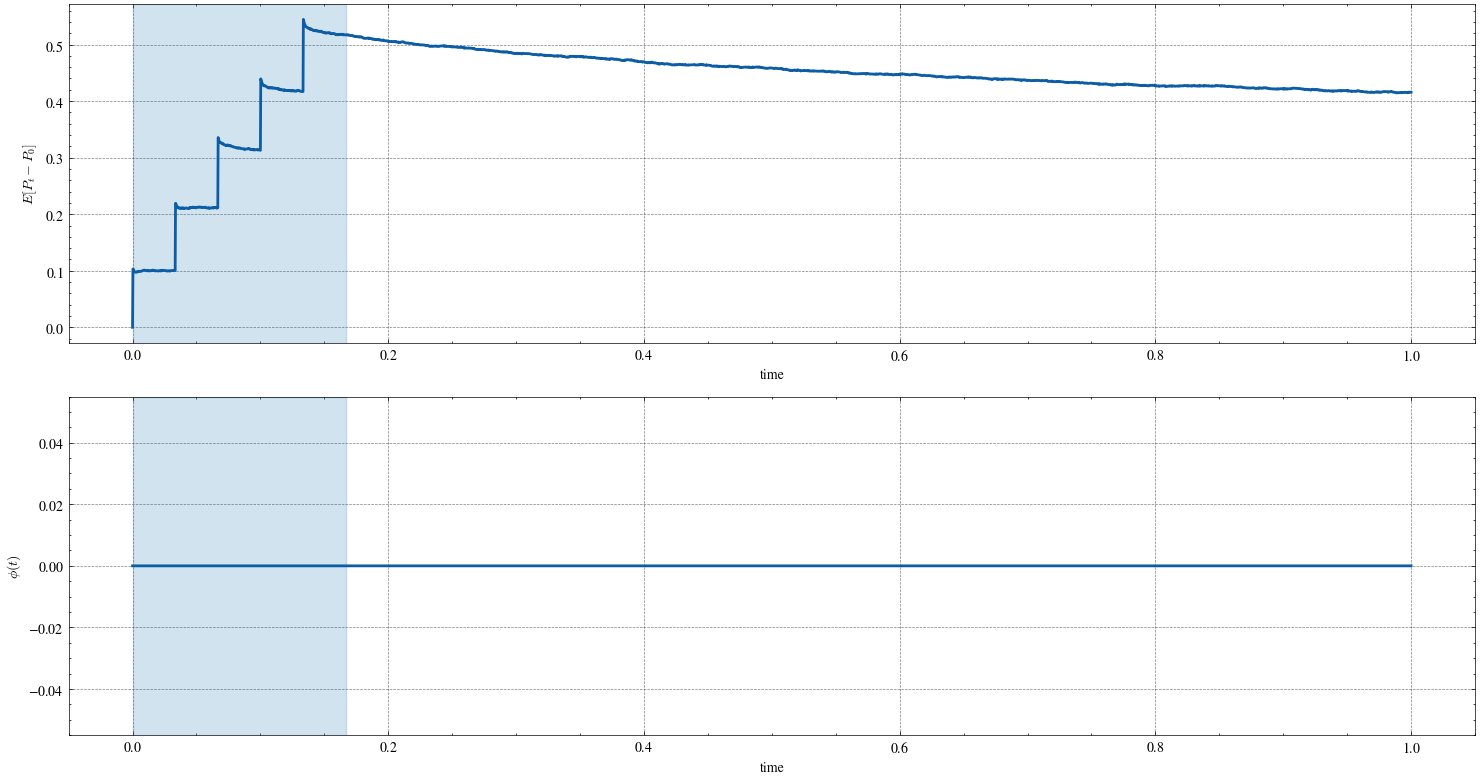

In [49]:
df = pl.read_csv(
    "/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_pct_25.csv",
    infer_schema_length=10000,
)
plot_impact(df)